In [1]:
import sys
print(sys.executable)

c:\Users\patri\anaconda3\python.exe


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
#from wordclou import WordCloud
import re
import gensim
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.utils import resample
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers.recurrent import LSTM, SimpleRNN, GRU

import Text_cleaning
from Classification import NNclassification
from sklearn.metrics import classification_report

from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import numpy as np
import pandas as pd
import keras
import keras.utils
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
np.random.seed(0)
import torch
import torch.nn as nn
from torch import optim
from random import shuffle

# Load the Dataset

In [4]:
df = pd.read_pickle("C:/Users/patri/Desktop/Informatik/Knowledge Discovery and Data Mining 1/emoji/emoji_train.pkl")      # Shape: (42627, 4)
test = pd.read_pickle("C:/Users/patri/Desktop/Informatik/Knowledge Discovery and Data Mining 1/emoji/emoji_test.pkl")        # (10657, 4)

df.head(4)

,tweet,emoji_class,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None


In [5]:
df = df.rename(columns={'emoji_class': 'label'})
df.head(4)

,tweet,label,emoji,predicted_class
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None
3,10min project w old footage #houstonphotograph...,2,📸,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42627 entries, 0 to 42626
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            42627 non-null  object
 1   label            42627 non-null  int64 
 2   emoji            42627 non-null  object
 3   predicted_class  0 non-null      object
dtypes: int64(1), object(3)
memory usage: 1.3+ MB
None
shape of train dataset (42627, 4)
0    16846
1     7801
2     6103
3     4884
4     2450
5     2431
6     2112
Name: label, dtype: int64


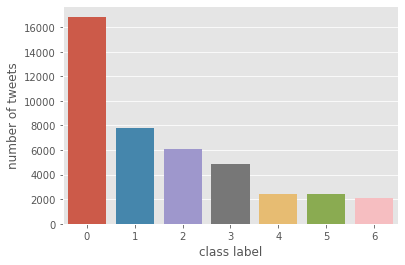

In [6]:
print(df.info())
print('shape of train dataset',df.shape)
print(df.label.value_counts())

sns.countplot(df.label,)
plt.xlabel('class label')
plt.ylabel('number of tweets')
plt.show()

In [7]:
# plt.hist(df[df['label']==1].tweet.str.len(),bins=20,label='class 1')
# plt.legend()
# plt.xlabel('length of tweets')
# plt.ylabel('number of tweets')
# plt.show()
# plt.hist(df[df['label']==0].tweet.str.len(),color='yellow',bins=20,label='class 0')
# plt.legend()
# plt.xlabel('length of tweets')
# plt.ylabel('number of tweets')
# plt.show()

## Preprocessing Tweet Text
   1. Removing Twitter Handles (@user)
   2. Removing urls from text
   3. Removing Punctuations, Numbers, and Special Characters
   4. Convert the word to lowercase
   5. Remove Stopwords
   6. Stemming the word
   7. Lemmatization
After which we collect the words used to describe positive and negative reviews

In [8]:
text=df['tweet'].values.tolist()
text_test=test['tweet'].values.tolist()
text+=text_test
print(len(text))

53284


In [9]:
import nltk
stopword=nltk.corpus.stopwords.words('english')
stopword.remove('not')
for index,text_ in enumerate(text):
    text_=re.sub(r'@[\w]*','',text_) #Removing Twitter Handles (@user)
    text_=re.sub(r'http/S+','',text_) #Removing urls from text 
    text_=re.sub(r'[^A-Za-z#]',' ',text_) #Removing Punctuations, Numbers, and Special Characters
    text_=" ".join(i.lower() for i in text_.split() if i.lower() not in stopword) #Removing stopword
    text[index]=text_

In [10]:
# #Stemming the word
# pt=PorterStemmer()
# wordnet=WordNetLemmatizer()
# for index,text_ in enumerate(text):
#     text_=" ".join(pt.stem(i) for i in text_.split())
#     text_=" ".join(wordnet.lemmatize(i) for i in text_.split())  
#     text[index]=text_

In [11]:
df['preprocess_tweet']=text[:len(df)]
df['length_tweet']=df['preprocess_tweet'].str.len()
test['preprocess_tweet']=text[len(df):]
df.head()

,tweet,label,emoji,predicted_class,preprocess_tweet,length_tweet
0,Brought to you courtesy of the red white and b...,5,🇺🇸,None,brought courtesy red white blue welcome home s...,52
1,@user #taotuesday @ TAO Downtown\n,3,🔥,None,#taotuesday tao downtown,24
2,Ready to celebrate America with @user Happy #i...,5,🇺🇸,None,ready celebrate america happy #independenceday...,60
3,10min project w old footage #houstonphotograph...,2,📸,None,min project w old footage #houstonphotographer...,81
4,Usually I don't put song on my insta but this ...,3,🔥,None,usually put song insta shit fire thank #aoifou...,59


# Featurization

## BOW

In [12]:
train=df.copy()
train.drop(columns=['tweet','label','predicted_class','preprocess_tweet'],inplace=True)

In [13]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(df['preprocess_tweet'])
bow_df=bow.transform(df['preprocess_tweet']).toarray()
print('feature name==',bow.get_feature_names()[:10])
print('number of uniqe words',bow_df.shape[1])
print('shape',bow_df.shape)
bow_train=pd.DataFrame(bow_df)
bow_train['length_tweet']=df['length_tweet']
bow_train['label']=df['label']
bow_train.head()

feature name== ['able', 'absolutely', 'academy', 'action', 'actually', 'adventure', 'adventures', 'af', 'afternoon', 'ago']
number of uniqe words 1000
shape (42627, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,52,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,24,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,60,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,81,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,59,3


## TF-IDF Features (Bi-Grams)

In [14]:
tfidf=TfidfVectorizer(ngram_range=(1, 2),min_df=2,max_features=1000)
tfidf.fit(df['preprocess_tweet'])
tfidf_df=tfidf.transform(df['preprocess_tweet']).toarray()
print('number of uniqe words',bow_df.shape[1])
print('shape',tfidf_df.shape)
tfidf_train=pd.DataFrame(tfidf_df)
tfidf_train['length_tweet']=df['length_tweet']
tfidf_train['label']=df['label']
tfidf_train.head()

number of uniqe words 1000
shape (42627, 1000)


,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,length_tweet,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24,3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81,2
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,59,3


In [15]:
tokenize=df['preprocess_tweet'].apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, vector_size= 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(df['preprocess_tweet']),epochs=20)

(5917033, 6125420)

In [16]:
#w2v_words = list(w2vec_model.wv.vocab)
w2v_words = list(w2vec_model.wv.index_to_key)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  57819
sample words  ['love', 'california', 'new', 'amp', 'happy', 'day', 'christmas', 'beach', '#', 'night', 'today', 'time', 'los', 'one', 'angeles', 'like', 'san', 'park', 'good', 'get', 'last', 'best', 'thank', 'city', 'back', 'got', 'great', 'family', 'birthday', 'beautiful', 'york', 'little', 'not', 'see', 'life', 'morning', 'tonight', 'home', 'th', 'much', 'vegas', 'fun', 'thanks', 'first', 'favorite', 'go', 'always', 'us', 'merry', 'las']


In [17]:
vector=[]
from tqdm import tqdm
for sent in tqdm(tokenize):
  sent_vec=np.zeros(100)
  count =0
  for word in sent: 
    if word in w2v_words:
      vec = w2vec_model.wv[word]
      sent_vec += vec 
      count += 1
  if count != 0:
    sent_vec /= count #normalize
  vector.append(sent_vec)
print(len(vector))
print(len(vector[0]))    

100%|██████████| 42627/42627 [00:29<00:00, 1466.11it/s]

42627
100


In [18]:
#example
l='father dysfunct selfish drag kid dysfunct'
count=0
vcc=np.zeros(100)
for word in l:
  if word in w2v_words:
    v=w2vec_model.wv[word]
    vcc+=v
    count+=1
vcc

array([-16.36927542,   6.55392817,  11.49387126,   5.66987196,
       -12.70865816, -13.08883423,  19.12736946,  11.47320775,
         1.1628068 , -14.11520332,   7.3683413 ,  -5.32931518,
        -5.21749292,   4.11420301,  -3.20428527,  -9.06879903,
         1.83370447, -17.2627849 ,   0.83287451, -11.78793339,
         0.6110172 ,   2.95915702,   2.81336355,  -5.22389352,
        -9.83929941,  -0.86004034,  -0.23687263,  -0.69271606,
         5.38712624,   1.22892275,  14.92904921,   5.21151937,
        -2.47556715,  -0.88862324,   7.05330562,  12.40849131,
       -16.40978537, -20.59939605,  -8.29029684,  -3.0108011 ,
        -1.3131752 ,  -2.57706671, -10.92995793,  -7.30298473,
        11.32359161, -10.49506658,   2.44339169,  -3.21357244,
         8.38497374,   3.172362  ,  13.28256148,  -4.14798349,
         8.64024285,   1.8618775 ,  -3.25439776, -18.91680697,
        22.43618363, -13.74201936,   5.92767859,  -9.70223299,
        -0.80646737,  -4.41843752,   9.0310217 ,   8.11

In [19]:
print('number of uniqe words',len(vector[1]))
w2v_train=pd.DataFrame(vector)
w2v_train['length_tweet']=df['length_tweet']
w2v_train['label']=df['label']
w2v_train.head()

number of uniqe words 100


,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,length_tweet,label
0,0.131330,0.257119,0.111924,-0.166165,-0.045617,-0.649502,0.657173,0.728285,0.001075,-0.531237,...,-0.231632,0.066270,0.840207,0.186599,0.679754,-0.642582,-0.087538,0.277394,52,5
1,-0.771990,-0.169134,-0.063250,-0.164557,-0.111910,-0.443053,0.183623,0.399059,0.311031,-0.089999,...,0.168617,-0.361960,0.350588,0.269561,-0.105211,-0.471534,-0.134738,-0.266171,24,3
2,-0.302335,0.298178,-0.372556,-0.076330,-0.143047,-0.379648,0.404911,0.743833,-0.187585,-0.443843,...,-0.012485,-0.487591,0.578209,0.335669,0.163435,-0.393470,0.439488,0.460025,60,5
3,-0.128766,0.294861,0.016739,0.072633,-0.044221,-0.667215,-0.036742,0.127695,-0.098436,0.045361,...,0.376718,0.111914,0.591521,-0.035954,0.007995,-0.578133,0.145660,-0.388465,81,2
4,0.145315,0.519912,-0.102919,0.183239,-0.398386,-0.483811,-0.370828,0.725865,-0.385090,0.042847,...,0.127841,0.385141,0.826059,-0.207079,-0.143951,-0.287566,0.206724,-0.036755,59,3


# Resample

## Upsampling BOW

In [20]:
bow_train.label.value_counts()

0    16846
1     7801
2     6103
3     4884
4     2450
5     2431
6     2112
Name: label, dtype: int64

shape (117922, 1002)


<AxesSubplot:xlabel='label', ylabel='count'>

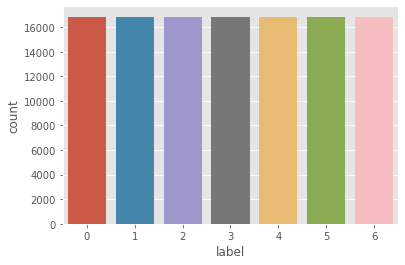

In [21]:
major_class_0,major_class_1, major_class_2, major_class_3, major_class_4, major_class_5, major_class_6 =bow_train.label.value_counts()
df_major0=bow_train[bow_train['label']==0]
df_major1=bow_train[bow_train['label']==1]
df_major2=bow_train[bow_train['label']==2]
df_major3=bow_train[bow_train['label']==3]
df_major4=bow_train[bow_train['label']==4]
df_major5=bow_train[bow_train['label']==5]
df_major6=bow_train[bow_train['label']==6]

df_minor1_upsampled = resample(df_major1, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor2_upsampled = resample(df_major2, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor3_upsampled = resample(df_major3, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor4_upsampled = resample(df_major4, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor5_upsampled = resample(df_major5, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor6_upsampled = resample(df_major6, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_bow_upsampled = pd.concat([df_major0, df_minor1_upsampled,df_minor2_upsampled, df_minor3_upsampled, df_minor4_upsampled, df_minor5_upsampled, df_minor6_upsampled])
print('shape',df_bow_upsampled.shape)
sns.countplot(df_bow_upsampled.label)

## Upsampling TF-IDF

shape (117922, 1002)


<AxesSubplot:xlabel='label', ylabel='count'>

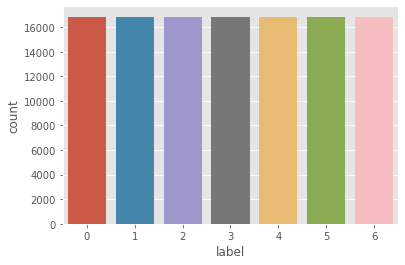

In [22]:
major_class_0,major_class_1, major_class_2, major_class_3, major_class_4, major_class_5, major_class_6=tfidf_train.label.value_counts()
df_major0=tfidf_train[tfidf_train['label']==0]
df_major1=tfidf_train[tfidf_train['label']==1]
df_major2=tfidf_train[tfidf_train['label']==2]
df_major3=tfidf_train[tfidf_train['label']==3]
df_major4=tfidf_train[tfidf_train['label']==4]
df_major5=tfidf_train[tfidf_train['label']==5]
df_major6=tfidf_train[tfidf_train['label']==6]

df_minor1_upsampled = resample(df_major1, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor2_upsampled = resample(df_major2, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor3_upsampled = resample(df_major3, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor4_upsampled = resample(df_major4, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor5_upsampled = resample(df_major5, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_minor6_upsampled = resample(df_major6, 
                                 replace=True,     # sample with replacement
                                 n_samples=major_class_0)
df_tfidf_upsampled  = pd.concat([df_major0, df_minor1_upsampled,df_minor2_upsampled, df_minor3_upsampled, df_minor4_upsampled, df_minor5_upsampled, df_minor6_upsampled])
print('shape',df_tfidf_upsampled.shape)
sns.countplot(df_tfidf_upsampled.label)

# Split Dataset

In [23]:
x=df_bow_upsampled.iloc[:,0:-1]
y=df_bow_upsampled['label']
x_train_bow,x_test_bow,y_train_bow,y_test_bow=train_test_split(x,y,test_size=0.2)

In [24]:
y_train_bow

12884    5
24101    4
27226    0
36484    3
36483    2
        ..
17343    2
42137    3
35750    5
36093    3
1828     6
Name: label, Length: 94337, dtype: int64

In [25]:
type(y_train_bow)

pandas.core.series.Series

In [26]:
x=df_tfidf_upsampled.iloc[:,0:-1]
y=df_tfidf_upsampled['label']
x_train_tfidf,x_test_tfidf,y_train_tfidf,y_test_tfidf=train_test_split(x,y,test_size=0.2)

## Metrics of Performance

In [27]:
def f1_score_(y_proba, y_pred):
  y_true = y_proba[:,1] >= 0.2
  y_true = y_true.astype(np.int) 
  f1 = f1_score(y_true, y_pred, average='macro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return f1

In [28]:
def recall(y_true,y_pred):
  y_true = y_true.astype(np.int) 
  recall_result = recall_score(y_true, y_pred, average='macro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return recall_result

In [29]:
def precision(y_true,y_pred):
  y_true = y_true.astype(np.int) 
  precision_result = precision_score(y_true, y_pred, average='macro') #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return precision_result

In [30]:
def cm(y_true,y_pred):
  y_true = y_true.astype(np.int) 
  confusion_result = confusion_matrix(y_true, y_pred) #  average setting, one of [None, 'micro', 'macro', 'weighted']
  return confusion_result

In [31]:
print(type(x_train_bow), x_train_bow.shape)
print(y_train_bow.shape)

<class 'pandas.core.frame.DataFrame'> (94337, 1001)
(94337,)


# Training

In [32]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

In [33]:
def get_model(hidden_units, input_dims, n_labels, dropout_r, model='rnn', feature='bow'):
    if model == 'baseline':
        model = LinearSVC(random_state=0, verbose=True, max_iter=10000)

    elif model == 'knn':
        model = KNeighborsClassifier(n_neighbors=3)
    
    elif model == 'rfc':
        model = RandomForestClassifier()

    elif model=='rnn' and feature=='bow':
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(hidden_units, input_dim = input_dims[1], activation = 'relu'))
        model.add(tf.keras.layers.Dropout(dropout_r)) # dropout is important to prevent model from overfitting
        model.add(tf.keras.layers.Dense(n_labels, activation = 'softmax'))
        adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
        model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
        #model.compile(loss='mean_squared_error', optimizer=adam, metrics = ['accuracy'])

    elif model=='rnn' and feature=='tfidf':
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(hidden_units, input_dim = input_dims[1], activation = 'relu'))
        model.add(tf.keras.layers.Dropout(dropout_r)) # dropout is important to prevent model from overfitting
        model.add(tf.keras.layers.Dense(n_labels, activation = 'softmax'))
        adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
        model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics = ['accuracy'])
        
    elif model=='lstm' and feature=='bow':
        # A simple LSTM network
        model = tf.keras.Sequential()
        model.add(LSTM(32))
        model.add(Dense(1))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
        #model.add(tf.keras.layers.Dense(hidden_units, input_dim = input_dims[1], activation = 'relu'))
        #tf.keras.layers.LSTM(4, return_sequences=True, return_state=True)
        # model.add(tf.keras.layers.LSTM(128, input_shape=(23585), return_sequences=True))
        # #model.add(tf.keras.layers.LSTM(4, return_sequences=True, return_state=True))
        # model.add(tf.keras.layers.Dropout(dropout_r))
        # #model.add(tf.keras.layers.LSTM(128, return_sequences=False))
        # #model.add(tf.keras.layers.Dropout(dropout_r))
        # model.add(tf.keras.layers.Dense(n_labels))
        # model.add(tf.keras.layers.Activation('softmax'))
        # #adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
        # model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])


        # model.add(Embedding(num_words, embed_dim, input_length = X.shape[1]))
        # model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
        # model.add(Dense(9,activation='softmax'))
        # model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])

    # elif model=='cnn' and feature=='bow':
    #     model = tf.keras.Sequential()
    #     inputs1 = Input(shape=(length,))
    #     embedding1 = Embedding(vocab_size, 100)(inputs1)
    #     conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    #     drop1 = Dropout(0.5)(conv1)
    #     pool1 = MaxPooling1D(pool_size=2)(drop1)
    #     flat1 = Flatten()(pool1)


        

    elif model=='rnn' and feature=='glove':
        # A simple RNN network to classify the emoji class from an input Sentence
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.SimpleRNN(64, input_shape=(30, 200), return_sequences=True))
        model.add(tf.keras.layers.Dropout(dropout_r))
        model.add(tf.keras.layers.SimpleRNN(64, return_sequences=False))
        model.add(tf.keras.layers.Dropout(dropout_r))
        model.add(tf.keras.layers.Dense(n_labels))
        model.add(tf.keras.layers.Activation('softmax'))
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    elif model=='lstm' and feature=='glove':
        # A simple LSTM network
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.LSTM(128, input_shape=(30, 200), return_sequences=True))
        model.add(tf.keras.layers.Dropout(dropout_r))
        model.add(tf.keras.layers.LSTM(128, return_sequences=False))
        model.add(tf.keras.layers.Dropout(dropout_r))
        model.add(tf.keras.layers.Dense(n_labels))
        model.add(tf.keras.layers.Activation('softmax'))
        #adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)
        model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    else:
        assert False
    return model

In [34]:
def probs_to_labels(y_probs):
    num_labels = [np.argmax(pred) for pred in y_probs]
    return num_labels

In [35]:
def NNclassification(X_train, X_test, y_train, y_test, n_units, dropout, n_epochs, model='rnn', feature='bow'):
    n_batches=32

    y_train_vals = y_train
    #X_train_vals = X_train

    # get indicator matrix with one-hot-encoded vectors per label (of all labels)
    y_train = to_cat_matrix(y_train)
    #y_test_val = to_cat_matrix(y_test)

    MLP = get_model(n_units, X_train.shape, y_train.shape[1], dropout, model, feature)
    print('Neural Net model constructed')
 
    #X_train, y_train = shuffle(X_train, y_train)
    if model == 'baseline':# or 'rfc' or 'knn':
        history = MLP.fit(X_train, y_train_vals)
    else:
        history = MLP.fit(X_train, y_train, epochs = n_epochs, batch_size = n_batches, validation_data=(X_test, to_cat_matrix(y_test)), verbose=False)
        #history = MLP.fit(X_train, y_train, epochs=n_epochs, batch_size=n_batches, verbose=False)
    
    #===================================================================
    #evaluate as described by tensorflow
    if model != 'baseline':  #or model != 'rfc':
        # evaluate on training data
        loss_train, acc_train = MLP.evaluate(X_train, y_train, verbose=True)     
    else:
        acc_train = MLP.score(X_train, y_train_vals)
   

    if model != 'baseline':
        # evaluate on training data
        loss_train, acc_train = MLP.evaluate(X_train, y_train, verbose=True)
    else:
        acc_train = MLP.score(X_train, y_train_vals)
    
    if model != 'baseline':
        # evaluate on training data
        loss_train, acc_train = MLP.evaluate(X_train, y_train, verbose=True)
    else:
        acc_train = MLP.score(X_train, y_train_vals)

    if model != 'baseline':
        # evaluate on test data
        loss_test, acc_test = MLP.evaluate(X_test, to_cat_matrix(y_test), verbose=True)
    else:
        acc_test = MLP.score(X_test, y_test)

    #evaluation done
    #===================================================================

    if model != 'baseline':
        print(history.history.keys())
        print(history.history['accuracy'])
        print(history.history['val_accuracy'])
        print(history.history['loss'])
        print(history.history['val_loss'])

        plot_history(history)
        # plt.plot(history.history['accuracy'])
        # plt.plot(history.history['val_accuracy'])
        # plt.plot(history.history['loss'])
        # plt.plot(history.history['val_loss'])

        #print(history.params)

    # classification report
    y_pred = MLP.predict(X_test)
    y_pred = probs_to_labels(y_pred)
    #y_test = y_test.tolist()
    results = classification_report(y_test, y_pred, labels = [0,1,2,3,4,5,6])

    # calc preicision scores
    precisionScore_sklearn_microavg = precision_score(y_test, y_pred, average='micro')
    precisionScore_sklearn_macroavg = precision_score(y_test, y_pred, average='macro')

    # calc recall scores 
    recallScore_sklearn_microavg = recall_score(y_test, y_pred, average='micro')
    recallScore_sklearn_macroavg = recall_score(y_test, y_pred, average='macro')

    # print stuff
    print("Classification Report: ")
    print(results)
    print("Precision_micro: {}".format(precisionScore_sklearn_microavg))
    print("Precision_macro: {}".format(precisionScore_sklearn_macroavg))
    print("Recall_micro: {}".format(recallScore_sklearn_microavg))
    print("Recall_macro: {}".format(recallScore_sklearn_macroavg))
    print("Training Accuracy: {:.4f}".format(acc_train))
    print("Testing Accuracy: {:.4f}".format(acc_test))
    
    if model != 'baseline':
        print("Training Loss: {:.4f}".format(loss_train))
        print("Testing Loss: {:.4f}".format(loss_test))

    return


In [36]:
def to_cat_matrix(y):
    """ 
    Binary one-hot encoding using an indicator matrix.
    This function converts labels to a categorical matrix which is of size N x K.
    Each row is a row vector with k-1 zeros and a single 1.
    """
    N = len(y)
    K = len(set(y))
    ind_matrix = np.zeros((N,K), dtype = int)
    for i, cat in enumerate(y):
        ind_matrix[i, int(cat)] = 1
    return ind_matrix

In [37]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [38]:
list_acc = []
list_loss = []

n_epoch = 10
N_NGRAMS = range(3, 5)

In [39]:
print(x_train_bow.shape, y_test_bow.shape)

(94337, 1001) (23585,)


Neural Net model constructed
738/738 [==============================] - 1s 665us/step - loss: 0.7757 - accuracy: 0.7316
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
[0.5100225806236267, 0.5799209475517273, 0.6005914807319641, 0.6237743496894836, 0.646490752696991, 0.6668539643287659, 0.6870368719100952, 0.6995558738708496, 0.714131236076355, 0.7237881422042847]
[0.5810896754264832, 0.5910112261772156, 0.6054272055625916, 0.6293407082557678, 0.6428238153457642, 0.666101336479187, 0.6832732558250427, 0.7077803611755371, 0.7164299488067627, 0.731609046459198]
[1.3717334270477295, 1.1621801853179932, 1.095395803451538, 1.0348368883132935, 0.9741426706314087, 0.9226119518280029, 0.8730759620666504, 0.8324480056762695, 0.7973388433456421, 0.7664461135864258]
[1.1677206754684448, 1.1174957752227783, 1.0854930877685547, 1.0174275636672974, 0.9730254411697388, 0.933214545249939, 0.891826331615448, 0.8390730023384094, 0.8064477443695068, 0.7757281064987183]
Classification Report: 

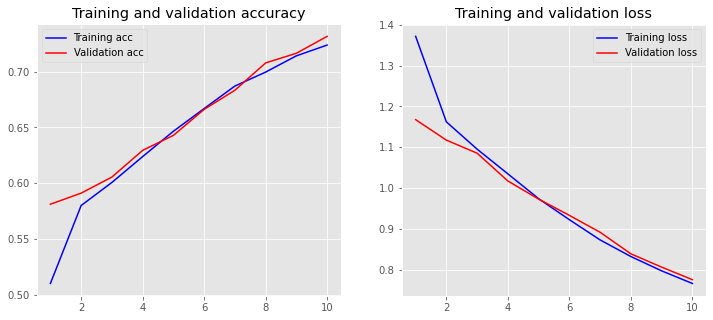

In [40]:
print("================================")
#NNclassification(x_train_bow, x_test_bow, y_train_bow, y_test_bow, n_units=100, dropout=0.2, n_epochs=n_epoch, model='lstm', feature='bow')
#NNclassification(x_train_bow, x_test_bow, y_train_bow, y_test_bow, n_units=100, dropout=0.2, n_epochs=n_epoch, model='baseline', feature='bow')
NNclassification(x_train_bow, x_test_bow, y_train_bow, y_test_bow, n_units=100, dropout=0.2, n_epochs=n_epoch, model='rnn', feature='bow')
#NNclassification(x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf, n_units=100, dropout=0.2, n_epochs=n_epoch, model='rnn', feature='tfidf')
#NNclassification(x_train_bow, x_test_bow, y_train_bow, y_test_bow, n_units=100, dropout=0.2, n_epochs=n_epoch, model='knn', feature='bow')
#NNclassification(x_train_bow, x_test_bow, y_train_bow, y_test_bow, n_units=100, dropout=0.2, n_epochs=n_epoch, model='rfc', feature='bow')